In [1]:
# Import packages 
import numpy as np
import xarray as xr
from scipy.stats import linregress as _linregress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import geopandas as gp
import regionmask
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator)

### Load Datasets

In [2]:
# ERA5 700
era5_700 = xr.open_dataset('/scratch/midway3/krucker01/ERA5/era5_q700_monthly_1deg_1980-2023.nc').compute()
era5_700 = era5_700.compute()*1000
era5_700 = era5_700.squeeze().rename({'lat':'latitude', 'lon':'longitude'})

In [3]:
# # AMIP
# files = np.sort(glob.glob('/project/tas1/itbaxter/for-tiffany/amip/180x360/hus/*'))
# files = np.delete(files, [0,8])
# amip = xr.open_mfdataset(files, combine = 'nested', concat_dim = 'member_id').sel(time = slice('1980','2014'))
# amip = amip.drop_sel(member_id = ['GISS-E2-2-G_r1i1p3f1', 'GISS-E2-2-G_r2i1p3f1', 'GISS-E2-2-G_r3i1p3f1',
#        'GISS-E2-2-G_r4i1p3f1', 'GISS-E2-2-G_r5i1p3f1','E3SM-1-0_r3i1p1f1'])
# amip = amip.compute()*1000
# amip_700 = amip.rename({'lat':'latitude', 'lon':'longitude'})
# amip_700['latitude'] = era5_700['latitude']
# amip_700['longitude'] = era5_700['longitude']
# amip_700.nbytes*1e-9

amip_700 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/AMIP/q_700_amip_annual_1980_2014.nc').compute()
amip_700['latitude'] = era5_700['latitude']
amip_700['longitude'] = era5_700['longitude']


In [4]:
def annual(ds):
    ds_ann = ds.groupby('time.year').mean('time')
    return ds_ann

In [5]:
amip_700_pi = xr.open_dataset('/project/tas1/itbaxter/for-tiffany/amip-piForcing/180x360/hus/q700_allmem_annual_1980_2014.nc').compute()*1000
amip_700_pi['latitude'] = era5_700['latitude']
amip_700_pi['longitude'] = era5_700['longitude']

In [6]:
# NGCM 700
ngcm_700 = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ngcm/q_700_ngcm_monthly_1981_2023.nc').compute()
ngcm_700 = ngcm_700.compute()*1000

In [7]:
ngcm_700_doc = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ngcm/ngcm_doc_q700_annual_mean.nc').compute()
ngcm_700_doc = ngcm_700_doc.compute()*1000
drop = list(ngcm_700_doc.isel(member=[4,5,6,7,8,11,15,18,19,22,23, 29, 32, 34, 36]).member.values)
ngcm_700_doc = ngcm_700_doc.drop_sel(member=drop)
ngcm_700_doc['latitude'] = ngcm_700['latitude']
ngcm_700_doc['longitude'] = ngcm_700['longitude']

In [8]:
# ACE2 700
ace2_700 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_q700_yearly_1980_2022.nc').compute()
ace2_700 = (ace2_700*1000).rename({'lat':'latitude', 'lon':'longitude'})
ace2_700['latitude'] = era5_700['latitude']
ace2_700['longitude'] = era5_700['longitude']

In [9]:
# ACE2 700
ace2_700_co2 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ace2_fixedCO2_q700_yearly_1980_2022.nc').compute()
ace2_700_co2 = (ace2_700_co2*1000).rename({'lat':'latitude', 'lon':'longitude'})
ace2_700_co2['latitude'] = era5_700['latitude']
ace2_700_co2['longitude'] = era5_700['longitude']

In [10]:
# Trend Function 
def linregress(da_y, da_x, dim=None):
    '''xarray-wrapped function of scipy.stats.linregress.
    Note the order of the input arguments x, y is reversed to the original scipy function.'''
    if dim is None:
        dim = [d for d in da_y.dims if d in da_x.dims][0]
    slope, intercept, r, p, stderr = xr.apply_ufunc(_linregress, da_x, da_y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        dask='allowed')
    predicted = da_x * slope + intercept
    slope.attrs['long_name'] = 'slope of the linear regression'
    intercept.attrs['long_name'] = 'intercept of the linear regression'
    r.attrs['long_name'] = 'correlation coefficient'
    p.attrs['long_name'] = 'p-value'
    stderr.attrs['long_name'] = 'standard error of the estimated gradient'
    predicted.attrs['long_name'] = 'predicted values by the linear regression model'
    return xr.Dataset(dict(slope=slope, intercept=intercept,
        r=r, p=p, stderr=stderr, predicted=predicted))

def draw_boxes(lon_min,lon_max,lat_min,lat_max):
    
    box_lon = [lon_min, lon_max, lon_max, lon_min, lon_min]
    box_lat = [lat_min, lat_min, lat_max, lat_max, lat_min]

    # Plot the box using plt.plot (on the same projection)
    ax.plot(box_lon, box_lat, color='k', linestyle='-', linewidth=2, zorder=20, transform=ccrs.PlateCarree())


# Mask function
def maskgen(shpfile, dat4mask, regionname):

    maskcoords = xr.Dataset({'latitude' : (['latitude'],dat4mask['latitude'].values)}, {'longitude' : (['longitude'],dat4mask['longitude'].values)})

    mask = np.zeros([maskcoords.latitude.size, maskcoords.longitude.size])

    shpcontents = gp.read_file(shpfile)

    for i in range(0,len(regionname),1):
        #print('masking '+regionname[i])
        try:
            region = shpcontents[shpcontents.NAME_1 == regionname[i]]

        except:
            region = shpcontents[shpcontents.NAME_0 == regionname[i]]
        maskt = regionmask.mask_geopandas(region, maskcoords['longitude'], maskcoords['latitude'])
        maskt = np.where(np.isnan(maskt), 0, 1)
        mask[:,:] = mask[:,:] + maskt[:,:]

    mask = np.where(mask == 0, np.nan, 1)
    mask = xr.DataArray(mask, coords = maskcoords.coords)

    return mask

# Area weighted average
def area_weighted_ave(ds):
    if 'lat' not in ds.dims:
        ds = ds.rename({'latitude':'lat','longitude':'lon'})
    coslat = np.cos(np.deg2rad(ds.lat))
    ds,coslat = xr.broadcast(ds,coslat)
    ds = ds * coslat
    #return ds.mean(('lat','lon'),skipna=True)
    return ds.sum(('lat','lon'),skipna=True)/((ds/ds)*coslat).sum(('lat','lon'),skipna=True)

def convert_longitude(ds):
    """
    Convert longitude from [0, 360] to [-180, 180].
    
    Parameters:
    - lon: array-like, input longitudes in the range [0, 360]
    
    Returns:
    - Converted longitudes in the range [-180, 180]
    """
    ds_new = ds.copy()
    lon = ds['longitude']  # Convert input to a NumPy array if it's not already
    converted_lon = (lon + 180) % 360 - 180  # Apply conversion
    ds_new.coords['longitude'] = converted_lon
    return ds_new.sortby('longitude')
    
def get_box(ds, lon1, lon2, lat1, lat2):
    ds_con = convert_longitude(ds)
    return area_weighted_ave(ds_con.sel(longitude=slice(lon1, lon2),latitude=slice(lat1, lat2)))

### Masks 

In [11]:
# USA mask
shpfile = "/scratch/midway3/krucker01/shp/gadm36_USA_1.shp"
states = ['California','Nevada','Utah','Arizona','New Mexico','Colorado']

mask_era5 = maskgen(shpfile, era5_700, states)

mask_amip = maskgen(shpfile, amip_700, states)

mask_ngcm = maskgen(shpfile, ngcm_700, states)

mask_ace2 = maskgen(shpfile, ace2_700, states)

In [12]:
# Land sea mask from ERA5
land_sea_mask = xr.open_dataset('/scratch/midway3/krucker01/shp/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')

#Regrid mask 1 degree
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = era5_700['latitude']
lon28 = era5_700['longitude']

mask_era5_course = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

ocean_mask = xr.where(mask_era5_course, 1, np.nan)
land_mask = xr.where(mask_era5_course, np.nan, 1)

#Regrid mask 2.8 degree
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = ngcm_700['latitude']
lon28 = ngcm_700['longitude']

mask_era5_course = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

ocean_mask_course = xr.where(mask_era5_course, 1, np.nan)
land_mask_course = xr.where(mask_era5_course, np.nan, 1)


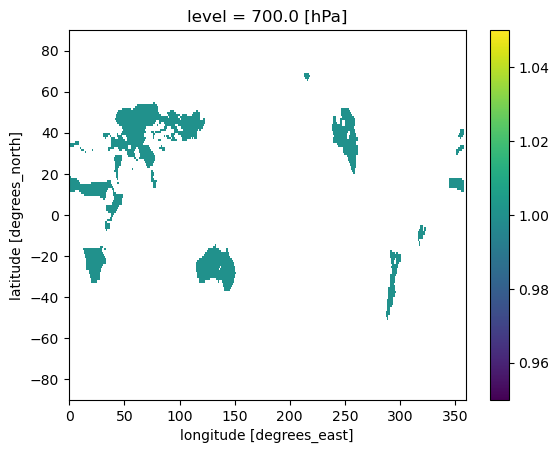

In [13]:
arid_mask = xr.open_dataarray('/scratch/midway2/krucker01/shp/aridity_mask_180x360.nc')

arid_mask = arid_mask.where(arid_mask>0.05).where(arid_mask<0.5)
arid_mask = xr.where(np.isnan(arid_mask),arid_mask, 1)

arid_mask['latitude'] = era5_700['latitude']
arid_mask['longitude'] = era5_700['longitude']

arid_mask.plot()

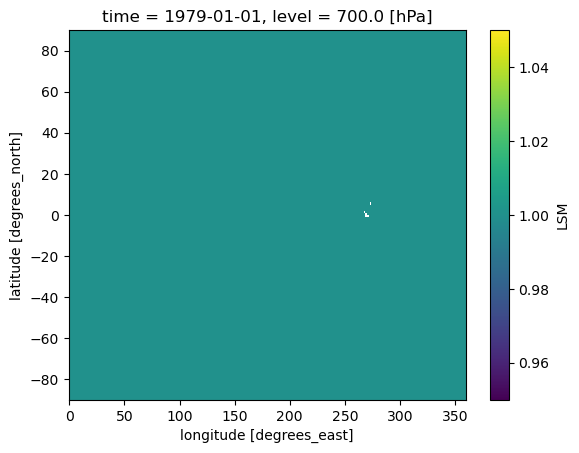

In [14]:
# Mask for removing high resolution islands 

island_mask = ocean_mask.copy()
min_lat = -15
max_lat = 9
min_lon = 260
max_lon = 275

island_mask = island_mask.where(ocean_mask.isnull(),1)

mask = (island_mask.latitude >= min_lat) & (island_mask.latitude <= max_lat) & (island_mask.longitude >= min_lon) & (island_mask.longitude <= max_lon)

min_lat = 13
max_lat = 20
min_lon = 295
max_lon = 310

mask2 = (island_mask.latitude >= min_lat) & (island_mask.latitude <= max_lat) & (island_mask.longitude >= min_lon) & (island_mask.longitude <= max_lon)


island_mask1 = island_mask.where(mask)
a = (island_mask1.where(island_mask1==1,5))
b = a.where(a==5)
island_mask1 = b.where(b!=5,1)
island_mask1.plot()

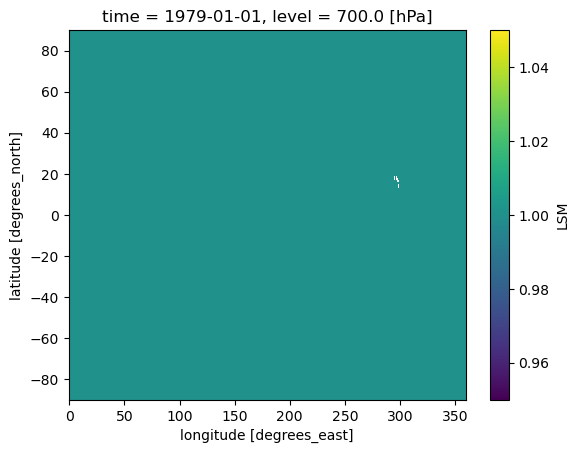

In [15]:
island_mask2 = island_mask.where(mask2)
a = (island_mask2.where(island_mask2==1,5))
b = a.where(a==5)
island_mask2 = b.where(b!=5,1)
island_mask2.plot()

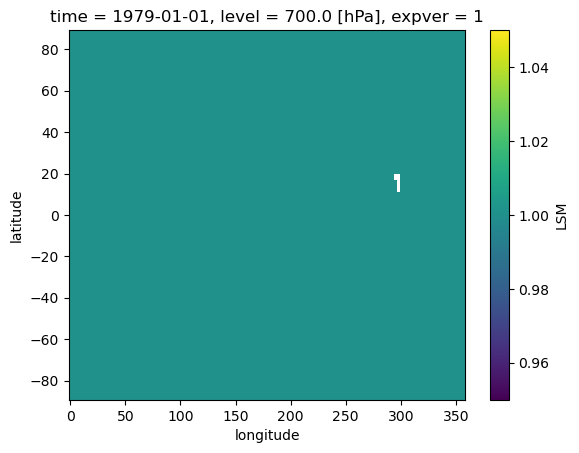

In [16]:
island_mask2_course = island_mask2.interp(latitude=ngcm_700['latitude'], longitude=ngcm_700['longitude'])
island_mask2_course.plot()

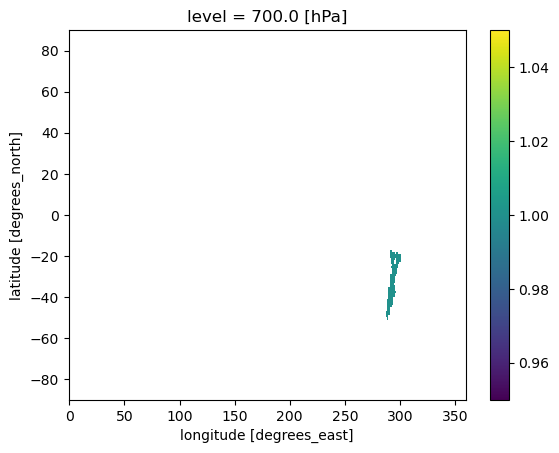

In [17]:
# Arid mask South America 1 degree
min_lat = -100
max_lat = 45
min_lon = 275
max_lon = 305


mask = (arid_mask.latitude >= min_lat) & (arid_mask.latitude <= max_lat) & (arid_mask.longitude >= min_lon) & (arid_mask.longitude <= max_lon)

arid_mask_SA = arid_mask.where(mask)
arid_mask_SA.plot()

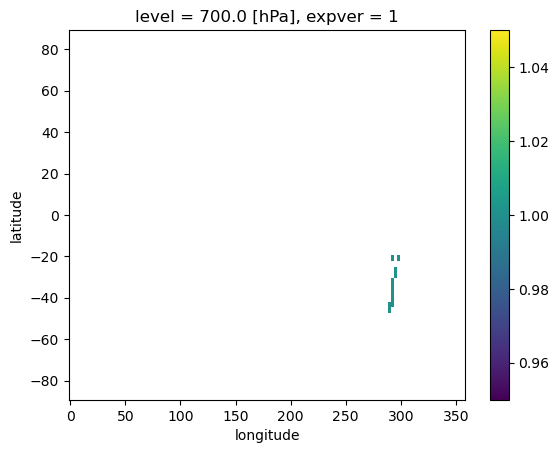

In [18]:
# South America Mask NGCM
lat01 = arid_mask_SA['latitude']
lon01 = arid_mask_SA['longitude']

lat28 = ngcm_700['latitude']
lon28 = ngcm_700['longitude']

arid_mask_SA_ngcm = arid_mask_SA.interp(latitude=lat28, longitude=lon28)
arid_mask_SA_ngcm.plot()

### CESM

In [19]:
cesm_700 = amip_700.sel(member_id = ['CESM2_r10i1p1f1', 'CESM2_r1i1p1f1',
       'CESM2_r2i1p1f1', 'CESM2_r3i1p1f1', 'CESM2_r4i1p1f1', 'CESM2_r5i1p1f1',
       'CESM2_r6i1p1f1', 'CESM2_r7i1p1f1', 'CESM2_r8i1p1f1', 'CESM2_r9i1p1f1'])

### Trends

In [20]:
# Land only 
era5_land = era5_700.where(ocean_mask==1)
amip_land = amip_700.where(ocean_mask==1)
amip_land_pi = amip_700_pi.where(ocean_mask==1)
cesm_land = cesm_700.where(ocean_mask==1)
ngcm_land = ngcm_700.where(ocean_mask_course==1)
ngcm_land_doc = ngcm_700_doc.where(ocean_mask_course==1)
ace2_land = ace2_700.where(ocean_mask==1)
ace2_land_co2 = ace2_700_co2.where(ocean_mask==1)

In [21]:
# ERA5 700 Trend
era5_700_lonavg = ((era5_land).groupby('time.year').mean('time')).sel(year = slice(1981,2014))
era5_700_trend = (linregress(era5_700_lonavg['Q'], era5_700_lonavg['year']).slope)*10

In [22]:
# AMIP 700
amip_700_lonavg = (((amip_land)).sel(year = slice(1981,2014)))
amip_700_trend = (linregress(amip_700_lonavg['hus'], amip_700_lonavg['year']).slope)*10

In [23]:
# AMIP 700 pi
amip_700_lonavg_pi = (((amip_land_pi)).sel(year = slice(1981,2014)))
amip_700_trend_pi = (linregress(amip_700_lonavg_pi['hus'], amip_700_lonavg_pi['year']).slope)*10

In [24]:
# CESM 700
cesm_700_lonavg = (((cesm_land)).sel(year = slice(1981,2014)))
cesm_700_trend = (linregress(cesm_700_lonavg['hus'], cesm_700_lonavg['year']).slope)*10

In [25]:
# NGCM 700

ngcm_700_lonavg = (((ngcm_land).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))
ngcm_700_trend = (linregress(ngcm_700_lonavg['__xarray_dataarray_variable__'], ngcm_700_lonavg['year']).slope)*10

In [26]:
ngcm_700_lonavg_doc = (((ngcm_land_doc)).sel(year = slice(1981,2014)))
ngcm_700_trend_doc = (linregress(ngcm_700_lonavg_doc['specific_humidity'], ngcm_700_lonavg_doc['year']).slope)*10

In [27]:
# ACE2 700
ace2_700_lonavg = (ace2_land).sel(year=slice(1981,2014))
ace2_700_trend = (linregress(ace2_700_lonavg['q700'],ace2_700_lonavg['year']).slope)*10

In [28]:
# ACE2 700
ace2_700_lonavg_co2 = (ace2_land_co2).sel(year=slice(1981,2014))
ace2_700_trend_co2 = (linregress(ace2_700_lonavg_co2['q700'],ace2_700_lonavg_co2['year']).slope)*10

### Time series

In [29]:
# SWUS time series 
era5_swu_time = area_weighted_ave((era5_land).where(mask_era5 == 1)).groupby('time.year').mean('time')
era5_swu_norm = era5_swu_time-(era5_swu_time.sel(year = slice(1981,1990)).mean().Q)

amip_swu_time = area_weighted_ave(((amip_land.mean('member_id'))).where(mask_amip == 1))
amip_swu_norm = (amip_swu_time-(amip_swu_time.sel(year=slice(1981,1990)).mean().hus))

amip_swu_time_pi = area_weighted_ave(((amip_land_pi.mean('member_id'))).where(mask_amip == 1))
amip_swu_norm_pi = (amip_swu_time_pi-(amip_swu_time_pi.sel(year=slice(1981,1990)).mean().hus))

ngcm_swu_time = area_weighted_ave(((ngcm_land.mean('member'))).where(mask_ngcm == 1)).groupby('time.year').mean('time')
ngcm_swu_norm = (ngcm_swu_time-(ngcm_swu_time.sel(year=slice(1981,1990)).mean().__xarray_dataarray_variable__))

ngcm_swu_time_doc = area_weighted_ave(((ngcm_land_doc.mean('member'))).where(mask_ngcm == 1))#.groupby('time.year').mean('time')
ngcm_swu_norm_doc = (ngcm_swu_time_doc-(ngcm_swu_time_doc.sel(year=slice(1981,1990)).mean().specific_humidity))#.__xarray_dataarray_variable__))

ace2_swu_time = area_weighted_ave((ace2_land.mean('member_id')).where(mask_ace2==1)).sel(year = slice(1981,2021))
ace2_swu_norm = (ace2_swu_time-(ace2_swu_time.sel(year=slice(1981,1990)).mean().q700))

ace2_swu_time_co2 = area_weighted_ave((ace2_land_co2.mean('member_id')).where(mask_ace2==1)).sel(year = slice(1981,2021))
ace2_swu_norm_co2 = (ace2_swu_time_co2-(ace2_swu_time_co2.sel(year=slice(1981,1990)).mean().q700))

In [31]:
# South America Time series
era5_sa_time = area_weighted_ave((era5_land).where(arid_mask_SA == 1)).groupby('time.year').mean('time')
era5_sa_norm = era5_sa_time-(era5_sa_time.sel(year = slice(1981,1990)).mean().Q)

amip_sa_time = area_weighted_ave(((amip_land).mean('member_id')).where(arid_mask_SA == 1))
amip_sa_norm = (amip_sa_time-(amip_sa_time.sel(year=slice(1981,1990)).mean().hus))

amip_sa_time_pi = area_weighted_ave(((amip_land_pi).mean('member_id')).where(arid_mask_SA == 1))
amip_sa_norm_pi = (amip_sa_time_pi-(amip_sa_time_pi.sel(year=slice(1981,1990)).mean().hus))

ngcm_sa_time = area_weighted_ave(((ngcm_land.mean('member'))).where(arid_mask_SA_ngcm == 1)).groupby('time.year').mean('time')
ngcm_sa_norm = (ngcm_sa_time-(np.nanmean(ngcm_sa_time.sel(year=slice(1981,1990)).__xarray_dataarray_variable__)))

ngcm_sa_time_doc = area_weighted_ave(((ngcm_land_doc.mean('member'))).where(arid_mask_SA_ngcm == 1))#.groupby('time.year').mean('time')
ngcm_sa_norm_doc = (ngcm_sa_time_doc-(np.nanmean(ngcm_sa_time_doc.sel(year=slice(1981,1990)).specific_humidity)))#.__xarray_dataarray_variable__))

ace2_sa_time = area_weighted_ave((ace2_land.mean('member_id')).where(arid_mask_SA == 1)).sel(year = slice(1981,2021))
ace2_sa_norm = (ace2_sa_time-(ace2_sa_time.sel(year=slice(1981,1990)).mean().q700))

ace2_sa_time_co2 = area_weighted_ave((ace2_land_co2.mean('member_id')).where(arid_mask_SA == 1)).sel(year = slice(1981,2021))
ace2_sa_norm_co2 = (ace2_sa_time_co2-(ace2_sa_time_co2.sel(year=slice(1981,1990)).mean().q700))

In [34]:
colors1 = plt.cm.GnBu(np.linspace(0, 1, 256))
colors2 = plt.cm.YlOrBr(np.linspace(0, 1, 256))[::-1]
new_colors = np.vstack((colors2[:], np.ones((40, 4)), colors1[:]))
new_cmap = LinearSegmentedColormap.from_list('GnBu_YlOrBr', new_colors, N=32)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


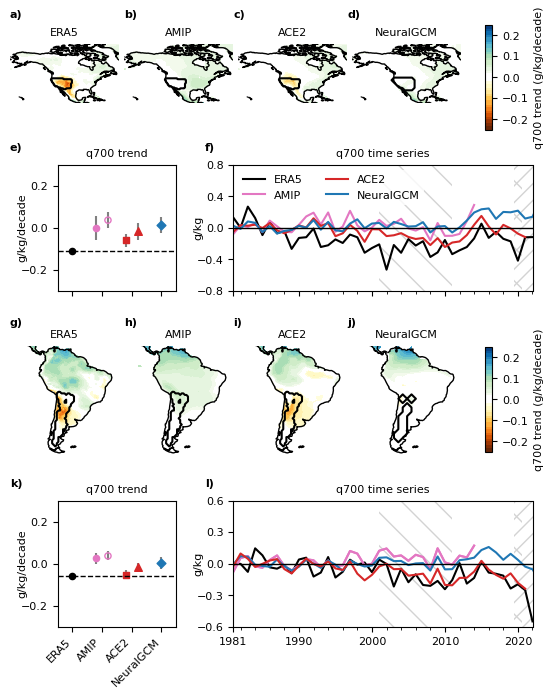

In [35]:
fig = plt.figure(figsize = (4.75,7))
plt.axis('off')
fontsize = 8
ssize = 20
levels = np.arange(-2.5e-1,2.5001e-1,0.01)
height = 0.18
map_height = 0.2
vspace = 0.06
map_width = 0.23
hspace = 0.01
time_width = 0.63
spread_width = 0.25
pad = -5
plt.rcParams['hatch.color'] = 'lightgray'
plt.rc('font', size=fontsize) 

lat = era5_700['latitude']
lon = era5_700['longitude']

lons, lats = np.meshgrid(lon, lat)

#a Southwest US ERA5
ax = fig.add_axes([0,(height*3+vspace*3)-vspace*0.5,map_width,map_height], projection=ccrs.PlateCarree())
plot = ax.contourf(lons, lats, era5_700_trend.where(island_mask2==1), transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

plt.contour(mask_era5.longitude, mask_era5.latitude, np.nan_to_num(mask_era5), colors = 'black', levels = [0,1])

ax.set_extent([-170,-50,15,80], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.set_title('ERA5', fontsize = fontsize)
ax.spines[:].set_visible(False)
ax.coastlines()

# AMIP SWUS 
ax = fig.add_axes([map_width+hspace,(height*3+vspace*3)-vspace*0.5,map_width,map_height], projection=ccrs.PlateCarree())
plot = ax.contourf(lons, lats, amip_700_trend.mean('member_id').where(island_mask2==1), transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

plt.contour(mask_era5.longitude, mask_era5.latitude, np.nan_to_num(mask_era5), colors = 'black', levels = [0,1])

ax.set_extent([-170,-50,15,80], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.set_title('AMIP', fontsize = fontsize)
ax.spines[:].set_visible(False)
ax.coastlines()

#b Soutwest US ACE2
ax = fig.add_axes([map_width*2+hspace*2,(height*3+vspace*3)-vspace*0.5,map_width,map_height], projection=ccrs.PlateCarree())
plot = ax.contourf(lons, lats, ace2_700_trend.mean('member_id').where(island_mask2==1), transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

plt.contour(mask_era5.longitude, mask_era5.latitude, np.nan_to_num(mask_era5), colors = 'black', levels = [0,1])

ax.set_extent([-170,-50,15,80], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.set_title('ACE2', fontsize = fontsize)
ax.spines[:].set_visible(False)
ax.coastlines()

#c Southwest US NGCM
ax = fig.add_axes([map_width*3+hspace*3,(height*3+vspace*3)-vspace*0.5,map_width,map_height], projection=ccrs.PlateCarree())
plot = ax.contourf(ngcm_700_trend.longitude, ngcm_700_trend.latitude, ngcm_700_trend.mean('member').T.where(island_mask2_course==1), transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

plt.contour(mask_ngcm.longitude, mask_ngcm.latitude, np.nan_to_num(mask_ngcm), colors = 'black', levels = [0,1])

ax.set_extent([-170,-50,15,80], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.set_title('NeuralGCM', fontsize = fontsize)
ax.spines[:].set_visible(False)
ax.coastlines()

# Colorbar 
cb_ax = fig.add_axes([1,((height*3+vspace*3)-vspace*0.5)+0.02,0.015,0.15])
cbar = fig.colorbar(plot, ax=ax, ticks = levels, orientation = 'vertical', cax = cb_ax)
cbar.set_ticks([-0.2,-0.1,0,0.1,0.2])
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('q700 trend (g/kg/decade)', size=fontsize)

# d Southwest US spread
ax = fig.add_axes([0.1,(height*2+vspace*2),spread_width,height])
ax.scatter([0], area_weighted_ave(era5_700_trend.where(mask_era5 == 1)).values, label = 'ERA5', c = 'k', s = ssize)
amip_swu = area_weighted_ave(amip_700_trend.where(mask_amip == 1)).values
cesm_swu = area_weighted_ave(cesm_700_trend.where(mask_amip == 1)).values
# amip_swu_pi = area_weighted_ave(amip_700_trend_pi.where(mask_amip == 1)).values

ngcm_swu = area_weighted_ave(ngcm_700_trend.where(mask_ngcm == 1)).values
# ngcm_swu_doc = area_weighted_ave(ngcm_700_trend_doc.where(mask_ngcm == 1)).values
ace2_swu = area_weighted_ave(ace2_700_trend.where(mask_ace2 == 1)).values
ace2_swu_co2 = area_weighted_ave(ace2_700_trend_co2.where(mask_ace2 == 1)).values

ax.scatter([0.8], amip_swu.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_swu, 0.05), ymax = np.quantile(amip_swu, 0.95), color = 'grey', zorder = -2)
ax.scatter([1.2], cesm_swu.mean(), edgecolor = '#E377C2', facecolor = 'none', marker = 'o', s = ssize)
ax.vlines([1.2], ymin = np.quantile(cesm_swu, 0.05), ymax = np.quantile(cesm_swu, 0.95), color = 'grey', zorder = -2)
# ax.scatter([1.4], amip_swu_pi.mean(), color = '#E377C2', marker = '^', s = ssize+10)
# ax.vlines([1.4], ymin = np.quantile(amip_swu_pi, 0.05), ymax = np.quantile(amip_swu_pi, 0.95), color = 'grey', zorder = -2)

ax.scatter([1.8], ace2_swu.mean(), c = '#D62728', marker = 's', s = ssize)
ax.vlines([1.8], ymin = np.quantile(ace2_swu, 0.05), ymax = np.quantile(ace2_swu, 0.95), color = 'grey', zorder = -2)
ax.scatter([2.2], ace2_swu_co2.mean(), color = '#D62728', marker = '^', s = ssize+10)
ax.vlines([2.2], ymin = np.quantile(ace2_swu_co2, 0.05), ymax = np.quantile(ace2_swu_co2, 0.95), color = 'grey', zorder = -2)

ax.scatter([3], ngcm_swu.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_swu, 0.05), ymax = np.quantile(ngcm_swu, 0.95), color = 'grey', zorder = -2)
# ax.scatter([2.6], ngcm_swu_doc.mean(), color = '#1F77B4', marker = 'D', s = ssize, facecolor = 'none')
# ax.vlines([2.6], ymin = np.quantile(ngcm_swu_doc, 0.05), ymax = np.quantile(ngcm_swu_doc, 0.95), color = 'grey', zorder = -2)




ax.set_title('q700 trend', fontsize = fontsize)
ax.axhline(area_weighted_ave(era5_700_trend.where(mask_era5 == 1)).values, color = 'k', linestyle = '--', linewidth = 1)
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_ylim([-0.3,0.3])
ax.set_yticks([-0.2,0,0.2])
ax.set_ylabel('g/kg/decade', fontsize=fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticklabels([])


# e Southwest US time series
ax = fig.add_axes([(0.1*2+spread_width)+0.02,(height*2+vspace*2),time_width,height])
ax.plot(era5_swu_norm.year, era5_swu_norm.Q, color = 'k', label = 'ERA5')
ax.plot(amip_swu_norm.year, amip_swu_norm.hus.mean('bnds'), color = '#E377C2', label = 'AMIP')
ax.plot(ace2_swu_norm.year, ace2_swu_norm.q700, color = '#D62728', label = 'ACE2')
ax.plot(ngcm_swu_norm.year, ngcm_swu_norm.__xarray_dataarray_variable__, color = '#1F77B4', label = 'NeuralGCM')
# ax.plot(ngcm_swu_norm_doc.year[:-1], ngcm_swu_norm_doc.specific_humidity[:-1], linestyle = '--', color = '#1F77B4')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_title('q700 time series', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylim([-0.8,0.8])
ax.set_yticks([-0.8,-0.4,0,0.4,0.8])
ax.set_ylabel('g/kg', fontsize = fontsize, labelpad = pad)
ax.set_xticklabels([])
ax.tick_params(axis='y', labelsize=fontsize)
ax.legend(bbox_to_anchor = None, loc = 'upper left', edgecolor = 'none', fontsize = fontsize, ncol = 2)


# f South America ERA5
ax = fig.add_axes([0,height+vspace*0.75,map_width,map_height-0.01], projection=ccrs.PlateCarree())

plot = ax.contourf(lons, lats, era5_700_trend.where(island_mask1==1), transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

ax.contour(arid_mask_SA.longitude,arid_mask_SA.latitude,arid_mask_SA.fillna(0),
           colors='k',
           transform=ccrs.PlateCarree(),
           levels = [0,1])

ax.set_title('ERA5', fontsize = fontsize)
ax.set_extent([-100,-30,-60, 13], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.coastlines()
ax.spines[:].set_visible(False)

# AMIP South America
ax = fig.add_axes([map_width+hspace,height+vspace*0.75,map_width,map_height-0.01], projection=ccrs.PlateCarree())
plot = ax.contourf(lons, lats, amip_700_trend.mean('member_id').where(island_mask2==1), transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

ax.contour(arid_mask_SA.longitude,arid_mask_SA.latitude,arid_mask_SA.fillna(0),
           colors='k',
           transform=ccrs.PlateCarree(),
           levels = [0,1])

ax.set_title('AMIP', fontsize = fontsize)
ax.set_extent([-100,-30,-60, 13], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.coastlines()
ax.spines[:].set_visible(False)


# g South America ACE2
ax = fig.add_axes([map_width*2+hspace*2,height+vspace*0.75,map_width,map_height-0.01], projection=ccrs.PlateCarree())

plot = ax.contourf(lons, lats, ace2_700_trend.mean('member_id').where(island_mask1==1), transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

ax.contour(arid_mask_SA.longitude,arid_mask_SA.latitude,arid_mask_SA.fillna(0),
           colors='k',
           transform=ccrs.PlateCarree(),
           levels = [0,1])

ax.set_title('ACE2', fontsize = fontsize)
ax.set_extent([-100,-30,-60, 13], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.coastlines()
ax.spines[:].set_visible(False)

# h South America NGCM
ax = fig.add_axes([map_width*3+hspace*3,height+vspace*0.75,map_width,map_height-0.01], projection=ccrs.PlateCarree())

plot = ax.contourf(ngcm_700_trend.longitude, ngcm_700_trend.latitude, ngcm_700_trend.mean('member').T, transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

ax.contour(arid_mask_SA_ngcm.longitude,arid_mask_SA_ngcm.latitude,arid_mask_SA_ngcm.fillna(0),
           colors='k',
           transform=ccrs.PlateCarree(),
           levels = [0,1])

ax.set_title('NeuralGCM', fontsize = fontsize)
ax.set_extent([-100,-30,-60, 13], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.coastlines()
ax.spines[:].set_visible(False)

# Colorbar 
cb_ax = fig.add_axes([1,(height+vspace)+0.01,0.015,0.15])
cbar = fig.colorbar(plot, ax=ax, ticks = levels, orientation = 'vertical', cax = cb_ax)
cbar.set_ticks([-0.2,-0.1,0,0.1,0.2])
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('q700 trend (g/kg/decade)', size=fontsize)

# i South America spread
ax = fig.add_axes([0.1,0,spread_width,height])
ax.scatter([0], area_weighted_ave(era5_700_trend.where(arid_mask_SA == 1)).values, label = 'ERA5', c = 'k', s = ssize)
amip_swu = area_weighted_ave(amip_700_trend.where(arid_mask_SA == 1)).values
cesm_swu = area_weighted_ave(cesm_700_trend.where(arid_mask_SA == 1)).values
# amip_swu_pi = area_weighted_ave(amip_700_trend_pi.where(arid_mask_SA == 1)).values

ngcm_swu = area_weighted_ave(ngcm_700_trend.where(arid_mask_SA_ngcm == 1)).values
# ngcm_swu_doc = area_weighted_ave(ngcm_700_trend_doc.where(arid_mask_SA_ngcm == 1)).values
ace2_swu = area_weighted_ave(ace2_700_trend.where(arid_mask_SA == 1)).values
ace2_swu_co2 = area_weighted_ave(ace2_700_trend_co2.where(arid_mask_SA == 1)).values


ax.scatter([0.8], amip_swu.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_swu, 0.05), ymax = np.quantile(amip_swu, 0.95), color = 'grey', zorder = -2)
ax.scatter([1.2], cesm_swu.mean(), edgecolor = '#E377C2', facecolor = 'none', marker = 'o', s = ssize)
ax.vlines([1.2], ymin = np.quantile(cesm_swu, 0.05), ymax = np.quantile(cesm_swu, 0.95), color = 'grey', zorder = -2)
# ax.scatter([1.4], amip_swu_pi.mean(), color = '#E377C2', marker = '^', s = ssize+10)
# ax.vlines([1.4], ymin = np.quantile(amip_swu_pi, 0.05), ymax = np.quantile(amip_swu_pi, 0.95), color = 'grey', zorder = -2)

ax.scatter([1.8], ace2_swu.mean(), c = '#D62728', marker = 's', s = ssize)
ax.vlines([1.8], ymin = np.quantile(ace2_swu, 0.05), ymax = np.quantile(ace2_swu, 0.95), color = 'grey', zorder = -2)
ax.scatter([2.2], ace2_swu_co2.mean(), color = '#D62728', marker = '^', s = ssize+10)
ax.vlines([2.2], ymin = np.quantile(ace2_swu_co2, 0.05), ymax = np.quantile(ace2_swu_co2, 0.95), color = 'grey', zorder = -2)

ax.scatter([3], np.nanmean(ngcm_swu), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.nanquantile(ngcm_swu, 0.05), ymax = np.nanquantile(ngcm_swu, 0.95), color = 'grey', zorder = -2)
# ax.scatter([2.6], np.nanmean(ngcm_swu_doc), color = '#1F77B4', marker = 'D', s = ssize, facecolor = 'none')
# ax.vlines([2.6], ymin = np.nanquantile(ngcm_swu_doc, 0.05), ymax = np.nanquantile(ngcm_swu_doc, 0.95), color = 'grey', zorder = -2)



ax.axhline(area_weighted_ave(era5_700_trend.where(arid_mask_SA == 1)).values, color = 'k', linestyle = '--', linewidth = 1)
ax.set_ylim([-0.3,0.3])
ax.set_yticks([-0.2,0,0.2])
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_title('q700 trend', fontsize = fontsize)
ax.set_ylabel('g/kg/decade', fontsize=fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticklabels(['ERA5','AMIP','ACE2','NeuralGCM'], fontsize = fontsize)
plt.xticks(rotation = 45, ha ='right')

# j South America time series
ax = fig.add_axes([(0.1*2+spread_width)+0.02,0,time_width,height])
ax.plot(era5_sa_norm.year, era5_sa_norm.Q, color = 'k')#, label = 'ERA5')
ax.plot(amip_sa_norm.year, amip_sa_norm.hus, color = '#E377C2')#, label = 'AMIP')
ax.plot(ngcm_sa_norm.year, ngcm_sa_norm.__xarray_dataarray_variable__, color = '#1F77B4')#, label = 'ACE2')
#ax.plot(ngcm_sa_norm_doc.year[:-1], ngcm_sa_norm_doc.specific_humidity[:-1], color = '#1F77B4', linestyle = '--')#, label = 'ACE2')
ax.plot(ace2_sa_norm.year, ace2_sa_norm.q700, color = '#D62728')
plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_title('q700 time series', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-0.6,0.6])
ax.set_yticks([-0.6,-0.3,0,0.3,0.6])
#ax.set_xticklabels([])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('g/kg', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='y', labelsize=fontsize)

fig.text(0,0.87, 'a)', weight = 'bold')
fig.text(0.24,0.87, 'b)', weight = 'bold')
fig.text(0.47,0.87, 'c)', weight = 'bold')
fig.text(0.71,0.87, 'd)', weight = 'bold')
fig.text(0,0.68, 'e)', weight = 'bold')
fig.text(0.41,0.68, 'f)', weight = 'bold')
fig.text(0,0.43, 'g)', weight = 'bold')
fig.text(0.24,0.43, 'h)', weight = 'bold')
fig.text(0.47,0.43, 'i)', weight = 'bold')
fig.text(0.71,0.43, 'j)', weight = 'bold')
fig.text(0,0.2, 'k)', weight = 'bold')
fig.text(0.41,0.2, 'l)', weight = 'bold')

plt.savefig('Thermo_fig_4_allmaps.png', dpi = 600, bbox_inches='tight')
plt.savefig('Thermo_fig_4_allmaps.eps', dpi = 600, bbox_inches='tight')

In [39]:
ngcm_700_trend_T = ngcm_700_trend.transpose('member','latitude','longitude')

amip_05 = np.quantile(amip_700_trend,0.05, axis = 0)
amip_95 = np.quantile(amip_700_trend,0.95, axis = 0)

ace2_05 = np.quantile(ace2_700_trend,0.05, axis = 0)
ace2_95 = np.quantile(ace2_700_trend,0.95, axis = 0)

ngcm_05 = np.quantile(ngcm_700_trend_T,0.05, axis = 0)
ngcm_95 = np.quantile(ngcm_700_trend_T,0.95, axis = 0)

In [40]:
class xESMF_REGRIDDER:
    def __init__(self,ds_out,method='conservative'):
        self.ds_out = ds_out
        self.method = method

    def add_lat_lon_bounds(self, ds, lat_name='lat', lon_name='lon'):
        """
        Function to add latitude and longitude bounds to a dataset
        for conservative regridding with xESMF.

        Parameters:
        - ds: xarray Dataset or DataArray containing latitude and longitude coordinates
        - lat_name: Name of the latitude coordinate in the dataset (default is 'lat')
        - lon_name: Name of the longitude coordinate in the dataset (default is 'lon')

        Returns:
        - ds: Dataset with added 'lat_bnds' and 'lon_bnds' variables
        """

        # Get latitude and longitude coordinates
        lat = ds[lat_name]
        lon = ds[lon_name]

        # Calculate latitude bounds
        lat_diff = np.diff(lat) / 2.0
        lat_bnds = np.empty((lat.size, 2), dtype=np.float64)
        lat_bnds[:, 0] = lat - np.concatenate(([lat_diff[0]], lat_diff))
        lat_bnds[:, 1] = lat + np.concatenate((lat_diff, [lat_diff[-1]]))

        # Calculate longitude bounds
        lon_diff = np.diff(lon) / 2.0
        lon_bnds = np.empty((lon.size, 2), dtype=np.float64)
        lon_bnds[:, 0] = lon - np.concatenate(([lon_diff[0]], lon_diff))
        lon_bnds[:, 1] = lon + np.concatenate((lon_diff, [lon_diff[-1]]))

        # Add latitude and longitude bounds to dataset
        ds.coords['lat_bnds'] = (('lat', 'bnds'), lat_bnds)
        ds.coords['lon_bnds'] = (('lon', 'bnds'), lon_bnds)

        return ds

    def regrid(self,ds):
        """
        Function to regrid xarray dataset or dataarray using xESMF.

        Parameters:
        - self.ds_out: xarray Dataset with the latitudes and longitudes you want to 
                       regrid to.
        - self.method: The regridding approach you want to use (i.e., bilinear (fastest),
                       conservative (optimal usually), nearest_n2s...)
        - ds: xarray Dataset or DataArray containing latitude and longitude coordinates

        Returns:
        - ds: Dataset regridded to the grid specified as ds_out.   

        """
        if self.method == 'conservative':
            #ds = ds.expand_dims('bnds')
            #ds['bnds'] = ('bnds', [ds.attrs.get('bnds', [1,2])])
            if 'bnds' not in list(ds.coords.keys()):
                 ds.coords['bnds'] = [1.0,2.0]
            if 'lat_bnds' not in list(ds.coords.keys()):
                ds = self.add_lat_lon_bounds(ds)
            if len(ds['lat_bnds'].dims) > 2:
                ds = self.add_lat_lon_bounds(ds)

        print(ds)
        regridder = xe.Regridder(ds, self.ds_out, self.method)
        dr_out = regridder(ds, keep_attrs=True)

        return dr_out

if __name__ == "__main__":
    # Example usage:

    # Reading in NGCM to get the grid to remap to
    # dir = '/scratch/midway3/itbaxter/NeuralGCM_Decadal_Simulations/climate_2.8_csp_pe/'
    #files = sorted(glob.glob(f'{dir}/*zarr'))
    new = xr.open_dataset("/scratch/midway3/krucker01/ai-models/ngcm/climate_2.8_csp_pe/tmp_monthly_1981-2023_csp_pe.nc") # files[0]
    #new = xr.open_dataset('/scratch/midway3/krucker01/ERA5/q2m_era5_1979-2023_360x180.nc')
    
    dims = list(new.dims)
    dim1 = [d for d in dims if 'lat' in d][0]
    dim2 = [d for d in dims if 'lon' in d][0]
    resolution = f'{len(new[dim1])}x{len(new[dim2])}'

    # Create xr.Dataset with output grid
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], new[dim1].data, {"units": "degrees_north"}),
            "lon": (["lon"], new[dim2].data, {"units": "degrees_east"}),
        }
    )


from cartopy.util import add_cyclic_point
import xesmf as xe


In [41]:
era5_64_128 = xESMF_REGRIDDER(ds_out,method='bilinear').regrid(era5_700_trend).rename({'lat':'latitude', 'lon':'longitude'})

era5_64_128['latitude'] = ngcm_700_trend['latitude']
era5_64_128['longitude'] = ngcm_700_trend['longitude']
era5_64_128

<xarray.DataArray 'slope' (latitude: 180, longitude: 360)> Size: 518kB
array([[-0.0030888 , -0.00307223, -0.00305823, ..., -0.00313385,
        -0.00311803, -0.00310158],
       [-0.00355696, -0.00351027, -0.00345845, ..., -0.00369083,
        -0.00364885, -0.00359806],
       [-0.00356002, -0.003441  , -0.00335272, ..., -0.00384686,
        -0.00376899, -0.00367844],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], shape=(180, 360))
Coordinates:
    level      float64 8B 700.0
  * longitude  (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5


<xarray.DataArray 'slope' (latitude: 64, longitude: 128)> Size: 66kB
array([[-0.00355891, -0.0033252 , -0.00309058, ..., -0.00420602,
        -0.00398668, -0.00377795],
       [-0.0033199 , -0.00292855, -0.00244442, ..., -0.00436824,
        -0.00400378, -0.00370145],
       [-0.00360719, -0.00331509, -0.00278505, ..., -0.00441561,
        -0.00425351, -0.00403461],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], shape=(64, 128))
Coordinates:
    level      float64 8B 700.0
    expver     int32 4B 1
  * latitude   (latitude) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * longitude  (longitude) float64 1kB 0.0 2.812 5.625 ... 351.6 354.4 357.2
Attributes:
    regrid_method:  bilinear

Text(0.5, 1.0, 'ERA5')

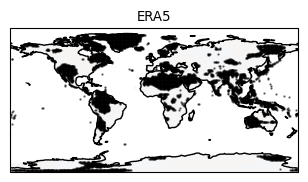

In [42]:
from scipy import stats
import numpy as np
from cartopy.util import add_cyclic_point

fig = plt.figure()

# First, calculate trends AND p-values for each grid point
def calculate_trend_and_pvalue(data, time_axis=0):
    """
    Calculate linear trends and p-values for each grid point
    data: array with time as first dimension
    """
    trends = np.zeros(data.shape[1:])
    p_values = np.zeros(data.shape[1:])
    
    for i in range(data.shape[1]):  # latitude
        for j in range(data.shape[2]):  # longitude
            x = np.arange(data.shape[time_axis])
            y = data[:, i, j]
            
            # Skip if all NaN
            if np.all(np.isnan(y)):
                trends[i, j] = np.nan
                p_values[i, j] = np.nan
            else:
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                trends[i, j] = slope
                p_values[i, j] = p_value
    
    return trends, p_values

# Calculate trends and p-values (assuming era5_tasmax is your time series)
era5_tasmax_trend_, era5_tasmax_pval = calculate_trend_and_pvalue(era5_700_lonavg['Q'])

# Plotting
ax = fig.add_axes([0,0.55,0.45,0.45], projection=ccrs.PlateCarree())
lat = era5_700['latitude']
lon = era5_700['longitude']

# Add cyclic point to both trends and p-values
datas, lons = add_cyclic_point(era5_tasmax_trend_, lon)
pvals_cyclic, _ = add_cyclic_point(era5_tasmax_pval, lon)

# Plot the trends
plot = ax.contourf(lons, lat, datas, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels=np.arange(-1.3,1.30001,step=0.025), extend='both')

# Add stippling where p < 0.05
sig_mask = pvals_cyclic < 0.05
lon_grid, lat_grid = np.meshgrid(lons, lat)
ax.scatter(lon_grid[sig_mask], lat_grid[sig_mask], 
           s=0.5, c='black', alpha=0.5, transform=ccrs.PlateCarree())

ax.coastlines()
ax.set_title('ERA5')

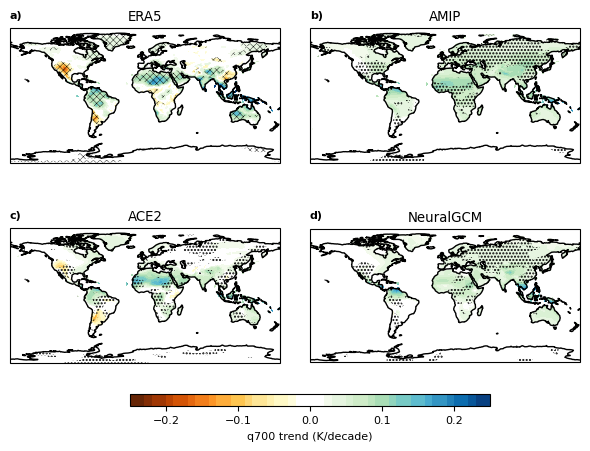

In [43]:
fig = plt.figure(figsize = (6,4))
density=5
plt.axis('off')
plt.rcParams['hatch.color'] = 'k'
plt.rcParams['hatch.linewidth'] = 0.3
levels = np.arange(-2.5e-1,2.5001e-1,0.01)

# ERA5
ax = fig.add_axes([0,0.55,0.45,0.45], projection=ccrs.PlateCarree())

lat = era5_700_trend['latitude']
lon = era5_700_trend['longitude']

datas,lons = add_cyclic_point(era5_700_trend,lon)

plot = ax.contourf(lons, lat, datas, transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels, extend = 'both')
ax.coastlines()
ax.set_title('ERA5')

sig_mask = pvals_cyclic < 0.05
lon_grid, lat_grid = np.meshgrid(lons, lat)
ax.contourf(lons, lat, pvals_cyclic, levels=[0, 0.05], 
            hatches=[density*'x'], colors='none', alpha=0,
            transform=ccrs.PlateCarree())

plt.rcParams['hatch.linewidth'] = 1
# AMIP
ax = fig.add_axes([0.5,0.55,0.45,0.45], projection=ccrs.PlateCarree())

datas,lons = add_cyclic_point(amip_700_trend.mean('member_id'),amip_700_trend.longitude)

plot = ax.contourf(lons, amip_700_trend.latitude, datas, transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)
ax.coastlines()
ax.set_title('AMIP')

over_amip = xr.where((amip_700_trend.mean('member_id').where((era5_700_trend > amip_95))).notnull(),1,np.nan)
under_amip = xr.where((amip_700_trend.mean('member_id').where((era5_700_trend < amip_05))).notnull(),1,np.nan)

ax.contourf(over_amip.longitude, over_amip.latitude, over_amip, levels=[0,0.5,1], colors='none',
        hatches=[density*'.',density*'.', density*','],
    transform = ccrs.PlateCarree())
ax.contourf(under_amip.longitude, under_amip.latitude, under_amip, levels=[0,0.5,1], colors='none',
        hatches=[density*'.',density*'.', density*'.'],
    transform = ccrs.PlateCarree())

# ACE2
ax = fig.add_axes([0,0.05,0.45,0.45], projection=ccrs.PlateCarree())

datas,lons = add_cyclic_point(ace2_700_trend.mean('member_id'),ace2_700_trend.longitude)

plot = ax.contourf(lons, ace2_700_trend.latitude, datas, transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)
ax.coastlines()
ax.set_title('ACE2')

over_ace2 = xr.where((ace2_700_trend.mean('member_id').where((era5_700_trend > ace2_95))).notnull(),1,np.nan)
under_ace2 = xr.where((ace2_700_trend.mean('member_id').where((era5_700_trend < ace2_05))).notnull(),1,np.nan)

ax.contourf(over_ace2.longitude, over_ace2.latitude, over_ace2, levels=[0,0.5,1], colors='none',
        hatches=[density*'.',density*'.', density*','],
    transform = ccrs.PlateCarree())
ax.contourf(under_ace2.longitude, under_ace2.latitude, under_ace2, levels=[0,0.5,1], colors='none',
        hatches=[density*'.',density*'.', density*','],
    transform = ccrs.PlateCarree())


# NGCM 

ax = fig.add_axes([0.5,0.05,0.45,0.45], projection=ccrs.PlateCarree())


datas,lons = add_cyclic_point(ngcm_700_trend_T.mean('member'),ngcm_700_trend_T.longitude)

plot = ax.contourf(lons,ngcm_700_trend_T.latitude, datas, transform=ccrs.PlateCarree(), levels = levels, cmap=new_cmap)
ax.coastlines()
ax.set_title('NeuralGCM')

over_ngcm = xr.where((ngcm_700_trend_T.mean('member').where((era5_64_128 > ngcm_95))).notnull(),1,np.nan)
under_ngcm = xr.where((ngcm_700_trend_T.mean('member').where((era5_64_128 < ngcm_05))).notnull(),1,np.nan)

ax.contourf(over_ngcm.longitude, over_ngcm.latitude, over_ngcm, levels=[0,0.5,1], colors='none',
        hatches=[density*'.'],
    transform = ccrs.PlateCarree())
ax.contourf(under_ngcm.longitude, under_ngcm.latitude, under_ngcm, levels=[0,0.5,1], colors='none',
        hatches=[density*'.'],
    transform = ccrs.PlateCarree())

# Colorbar
cb_ax = fig.add_axes([0.2,0,0.6,0.03])
cbar = fig.colorbar(plot, ax=ax, ticks = levels, orientation = 'horizontal', cax = cb_ax, extend = 'both')
cbar.set_ticks([-0.2,-0.1,0,0.1,0.2])
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('q700 trend (K/decade)', size=fontsize)

fig.text(0,0.97, 'a)', weight = 'bold')
fig.text(0.5,0.97, 'b)', weight = 'bold')
fig.text(0,0.47, 'c)', weight = 'bold')
fig.text(0.5,0.47, 'd)', weight = 'bold')

plt.savefig('SI_q700_global_map.eps', dpi = 450, bbox_inches='tight')
plt.savefig('SI_q700_global_map.png', dpi = 450, bbox_inches='tight')